# 电网选线规划-遥感分割与路径搜索

In [267]:

import os
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns
import warnings
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pylab import mpl, plt
import matplotlib.patches as mpatches

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = 'MiSans'


## 遥感分割类型的基本定义

In [268]:
# 定义表格数据
df_label = {
    "类别编号": [0, 1, 2, 3, 4, 5, 6],
    "类别名称（英文）": ["background", "building", "road", "water", "barren", "forest", "agriculture"],
    "类别名称（中文）": ["背景", "建筑", "道路", "水体", "裸土", "林地", "耕地"],
    "说明": [
        "通常为未分类区域",
        "房屋、厂房等",
        "包括主干道、辅路等",
        "包括河流、湖泊等",
        "裸露土地、沙地等",
        "森林、树木等",
        "农田、种植区域"
    ]
}
# 构造类别编号到 RGB 的映射（索引即为类别编号）
id2color = np.array(
    [
        [0, 0, 0],  # 0 - 背景
        [220, 20, 60],  # 1 - 建筑
        [128, 64, 128],  # 2 - 道路
        [0, 0, 255],  # 3 - 水体
        [210, 180, 140],  # 4 - 裸土
        [34, 139, 34],  # 5 - 林地
        [255, 255, 0],  # 6 - 耕地
    ],
    dtype=np.uint8,
)
df_label = pd.DataFrame(df_label)
df_label

,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
1,1,building,建筑,房屋、厂房等
2,2,road,道路,包括主干道、辅路等
3,3,water,水体,包括河流、湖泊等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等
6,6,agriculture,耕地,农田、种植区域


## 遥感分割，多专家模型MOE

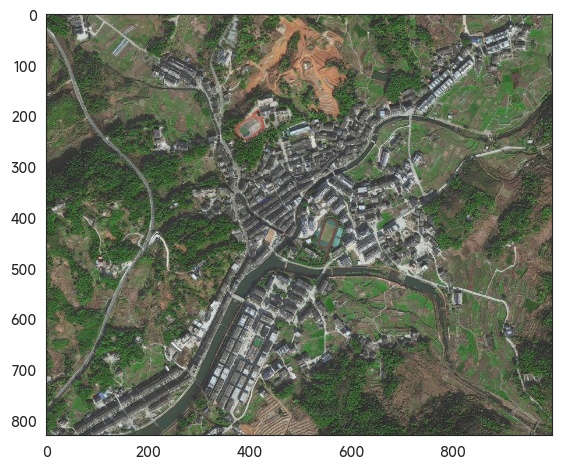

In [269]:
from infer_all import road_seg, all_seg, overlay_mask_on_image, resize_and_save, resize_and_save_2

img_path = "../photo/1173.png"
img_path = "../photo/wz_1.png"  # https://map.baidu.com/@13404714.629512599,3173311.453560461,17.89z/maptype%3DB_EARTH_MAP
# img_path = "../photo/wz_2.png"  # https://map.baidu.com/@13404670.488946166,3173333.393695217,18.64z/maptype%3DB_EARTH_MAP
img_path = "../photo/4.jpg"
img_path = "../photo/wz_0.png"
img_path = "../photo/wz_3.jpg"
img_path = "../photo/3.jpg"
img_path = "../photo/14.png"
io.imshow(img_path)  # 查看原图

In [270]:
# img_path = resize_and_save_2(img_path, (256, 512))

In [271]:
from road_search import a_star_pathfinding
from infer_all import road_seg, all_seg, overlay_mask_on_image

# ✅ 道路分割模型（只分出 road 类）
road_mask = road_seg(
    image_path=img_path,
    config_path="configs/road_seg/pp_liteseg_stdc1_deepglobe_infer.yml",
    model_path="pp_liteseg_stdc1_deepglobe.pdparams",
    save_dir="../output/test",
)

# ✅ 多类地物分割模型（输出0~6的语义mask）
mask = all_seg(
    image_path=img_path,
    config_path="configs/segmenter/segmenter_rural2.yml",
    model_path="../output/segmenter_rural2/iter_87500/model.pdparams",
    save_dir="../output/test",
)
# water_mask = all_seg(
#     image_path=img_path,
#     config_path="configs/segmenter/segmenter_rural2.yml",
#     model_path="../output/segmenter_rural2/iter_87500/model.pdparams",
#     save_dir="../output/test",
# )

# ✅ 可选备份一份副本（用于后续处理）
mask_2 = mask.copy()
mask[road_mask == 1] = 2  # 2: road
# mask[water_mask == 1] = 3  # 3: water

[🚗] 正在用 PP-LiteSeg 道路模型推理图像：../photo/14.png
[✅] 成功读取道路分割结果：../output/test\pseudo_color_prediction\14.png
[🚀] 正在用 PP-LiteSeg 推理图像（多分类）：../photo/14.png
[✅] 成功读取输出文件：../output/test\pseudo_color_prediction\14.png


In [272]:
# io.imshow(mask)
mask_val = mask.copy()
df_label

,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
1,1,building,建筑,房屋、厂房等
2,2,road,道路,包括主干道、辅路等
3,3,water,水体,包括河流、湖泊等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等
6,6,agriculture,耕地,农田、种植区域


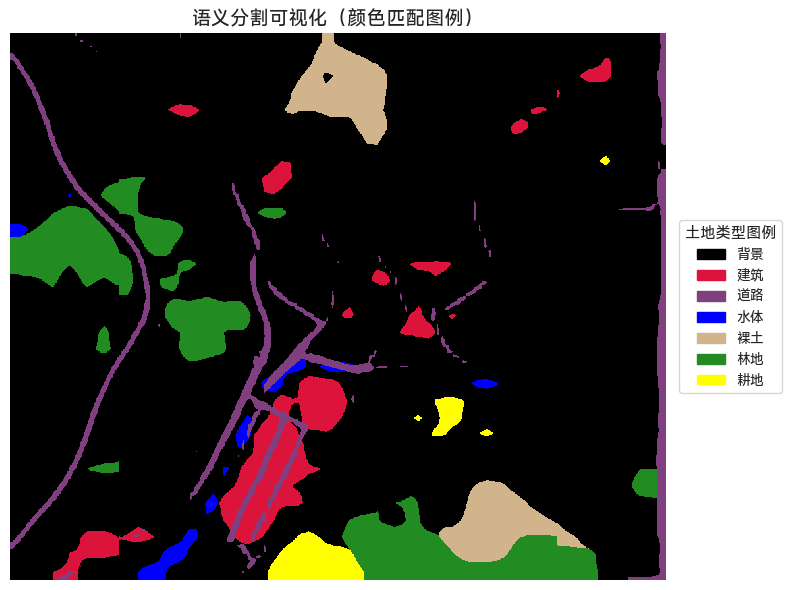

In [273]:
# ===== 2. 渲染颜色图像 =====

seg_rgb = id2color[mask_val]  # shape: (H, W, 3)

# ===== 3. 绘制图像并添加图例 =====

plt.figure(figsize=(8, 6))
plt.title("遥感分割可视化（颜色匹配图例）", fontsize=14)
io.imshow(seg_rgb)  # 显示 RGB 显示图像
plt.axis("off")

# 构造图例
legend_patches = []
for idx, row in df_label.iterrows():
    class_id = row["类别编号"]
    label_cn = row["类别名称（中文）"]
    color_rgb = id2color[class_id] / 255.0  # 归一化
    patch = mpatches.Patch(color=color_rgb, label=label_cn)
    legend_patches.append(patch)

# 添加图例到图像右侧
plt.legend(
    handles=legend_patches,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
    title="土地类型图例",
    fontsize=10,
    title_fontsize=11,
    frameon=True
)

plt.tight_layout()
plt.show()

## 地图任意选点，进行路径规划

In [274]:
# # 随机选两个不同的可通行区域像素点（排除房屋）
# passable_values = [0, 2, 4, 5]  # 可通行区域
# passable_indices = np.argwhere(np.isin(mask_val, passable_values))
# 
# # 随机选择两个点
# start_idx, end_idx = passable_indices[
#     np.random.choice(len(passable_indices), 2, replace=False)
# ]
# start_idx = tuple((20, 670))
# end_idx = tuple((950, 450))
# # 可视化
# plt.figure(figsize=(6, 6))
# plt.imshow(mask_val, cmap="gray")
# # 起点圆圈（o）
# plt.scatter(start_idx[1], start_idx[0], c="red", marker="o", s=200, label="Start")
# 
# # 终点叉号（x）
# plt.scatter(end_idx[1], end_idx[0], c="red", marker="x", s=200, label="End")
# 
# plt.title("地图上任意两点选线规划")
# plt.legend()
# plt.axis("off")
# plt.tight_layout()
# plt.show()
# 
# (start_idx, end_idx)

## 进行随机或者指定选点

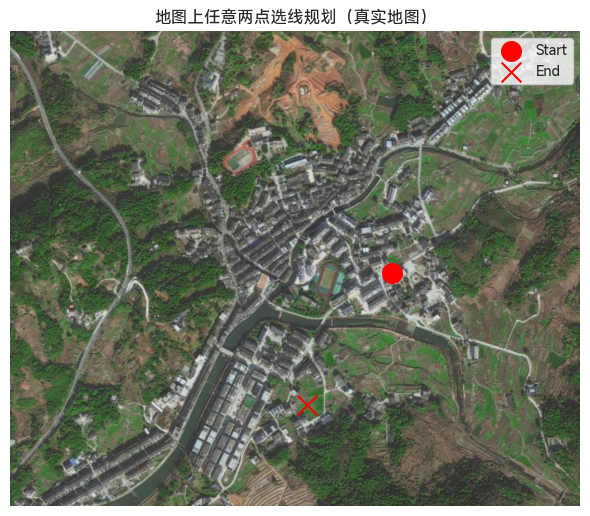

(array([423, 667], dtype=int64), array([653, 518], dtype=int64))

In [275]:
# 随机选两个不同的可通行区域像素点（排除房屋）
passable_values = [0, 2, 4, 5]  # 可通行区域
passable_indices = np.argwhere(np.isin(mask_val, passable_values))

# 随机选择两个点
start_idx, end_idx = passable_indices[
    np.random.choice(len(passable_indices), 2, replace=False)
]
# start_idx = tuple((20, 670))
# end_idx = tuple((650, 450))
# 可视化
plt.figure(figsize=(6, 6))
img_val = io.imread(img_path)[:, :, :3]
plt.imshow(img_val)
# 起点圆圈（o）
plt.scatter(start_idx[1], start_idx[0], c="red", marker="o", s=200, label="Start")

# 终点叉号（x）
plt.scatter(end_idx[1], end_idx[0], c="red", marker="x", s=200, label="End")

plt.title("地图上任意两点选线规划（真实地图）")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

(start_idx, end_idx)

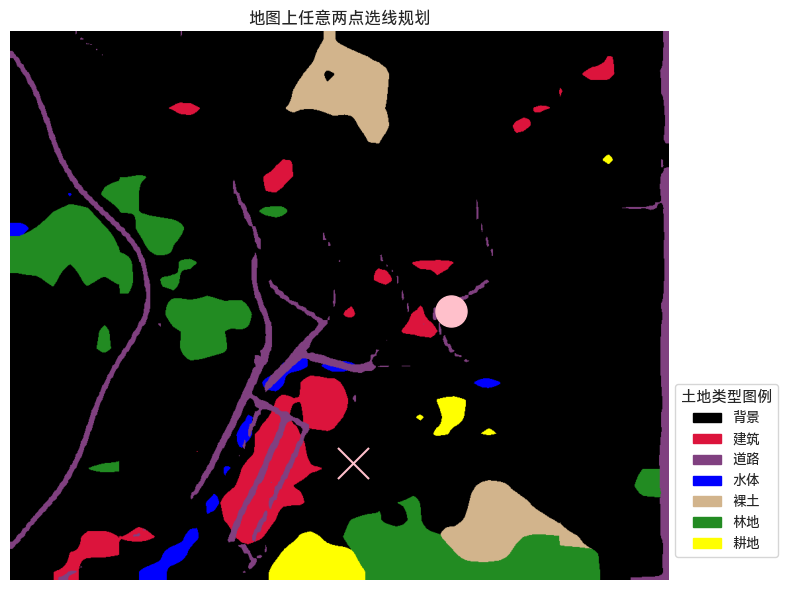

In [276]:
# 构造语义图像（RGB）
seg_rgb = id2color[mask_val]

plt.figure(figsize=(8, 6))  # 加宽以留图例位置
plt.title("地图上任意两点选线规划")
plt.imshow(seg_rgb)
plt.axis("off")

# 构建 legend patch（颜色块 + 中文名）
legend_patches = []
for idx, row in df_label.iterrows():
    class_id = row["类别编号"]
    label_cn = row["类别名称（中文）"]
    color_rgb = id2color[class_id] / 255.0
    patch = mpatches.Patch(color=color_rgb, label=label_cn)
    legend_patches.append(patch)

# 添加 legend（图右侧中部）
plt.legend(
    handles=legend_patches,
    loc='center left',
    bbox_to_anchor=(1.01, 0.2),
    borderaxespad=0.0,
    title="土地类型图例",
    fontsize=10,
    title_fontsize=11,
    frameon=True
)

# 起点圆圈（o）
plt.scatter(start_idx[1], start_idx[0], c="pink", marker="o", s=500, label="Start")

# 终点叉号（x）
plt.scatter(end_idx[1], end_idx[0], c="pink", marker="x", s=500, label="End")

plt.tight_layout()
plt.show()


## 定义可通行区域

In [277]:
df_label.iloc[passable_values]  # 可通行区域

,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
2,2,road,道路,包括主干道、辅路等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等


## 图像含有的分割类型

In [278]:
print(np.unique(mask_val))
df_label.iloc[np.unique(mask_val)]  # 图片中含有的元素

[0 1 2 3 4 5 6]


,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
1,1,building,建筑,房屋、厂房等
2,2,road,道路,包括主干道、辅路等
3,3,water,水体,包括河流、湖泊等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等
6,6,agriculture,耕地,农田、种植区域


## Cost Map构造与可视化

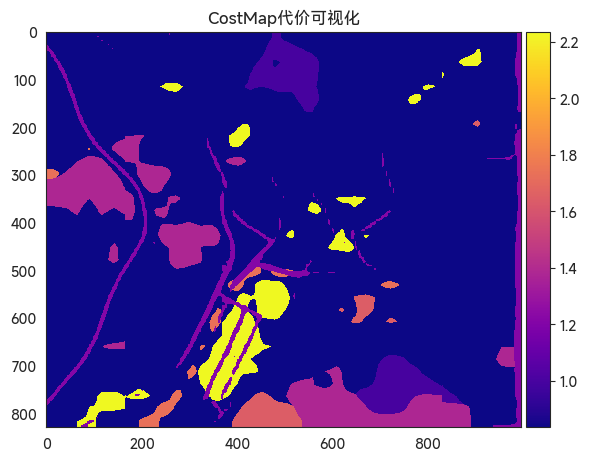

In [279]:
from queue import PriorityQueue

cost_map = np.full_like(mask_val, 1e5, dtype=float)  # 默认高代价（如房屋、不可通行区域）

cost_map[mask_val == 0] = 5  # 背景（可通行）
cost_map[mask_val == 2] = 30  # 道路（可通行）

cost_map[mask_val == 4] = 10  # 裸土（较低成本）
cost_map[mask_val == 5] = 80  # 植被、林地（中等成本）
cost_map[mask_val == 6] = 500  # 农田（高成本）
cost_map[mask_val == 3] = 1000  # 水体（非常高成本）

plt.figure(figsize=(6, 6))
plt.title("CostMap代价可视化")
io.imshow(np.log10(cost_map) ** 0.5, cmap='plasma')

## 任意两点的路径搜索

In [280]:
# ======== 3. A* 搜索 ========
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


from road_search import a_star_pathfinding

h, w = cost_map.shape

path = a_star_pathfinding(start_idx=start_idx, end_idx=end_idx, cost_map=cost_map)

[✅] 成功找到从起点到终点的路径！
Path length (pixels): 231


## 路径输出的标准格式

In [281]:
# ======== 4.5 输出路径矩阵 ========
if path:
    path_array = np.array([[x, y] for (x, y) in path])  # shape (n, 2)

# io.imshow(seg_rgb)
pd.DataFrame(path_array, columns=["x", "y"])

,x,y
0,423,667
1,424,666
2,425,665
3,426,664
4,427,663
...,...,...
226,649,518
227,650,518
228,651,518
229,652,518


## 计算路径的总代价

In [282]:
road_cost_list = [cost_map[i] for i in path]
np.array(road_cost_list).sum()

1155.0

## 路径在地图上的可视化

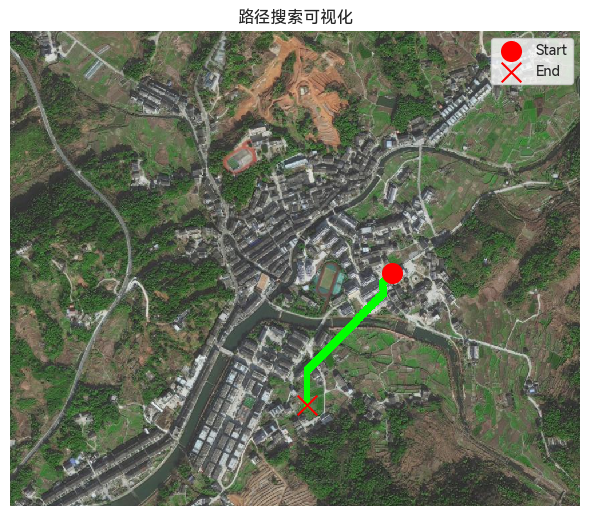

In [283]:
img = io.imread(img_path)  # shape: (H, W, 3)

# === 绘制路径（绿色） ===
overlay = img.copy()[:, :, :3]
# overlay = overlay_mask_on_image(overlay, mask_val, id2color, alpha=0.3)
path_color = [0, 255, 0]  # RGB 绿色
thickness = 5  # 可调粗细

h, w = overlay.shape[:2]
for i, j in path:
    for di in range(-thickness, thickness + 1):
        for dj in range(-thickness, thickness + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < h and 0 <= nj < w:
                overlay[ni, nj] = path_color

plt.figure(figsize=(6, 6))
io.imshow(overlay)

# 起点圆圈（o）
plt.scatter(start_idx[1], start_idx[0], c="red", marker="o", s=200, label="Start")
# 终点叉号（x）
plt.scatter(end_idx[1], end_idx[0], c="red", marker="x", s=200, label="End")
plt.title("路径搜索可视化")
plt.legend()
plt.axis("off")
plt.tight_layout()
# plt.show()

(830, 996, 3)


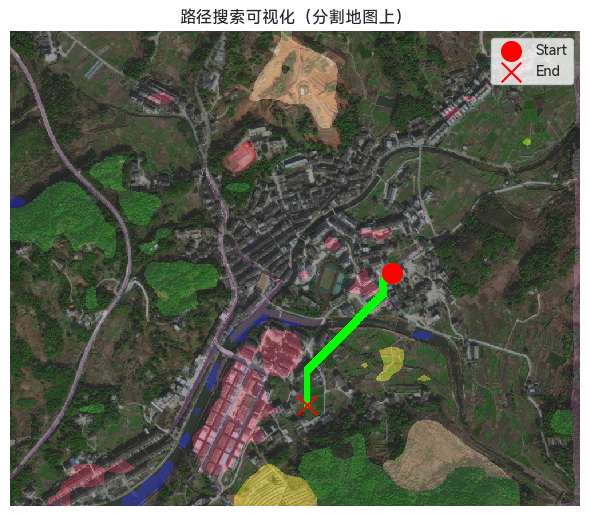

In [284]:
img = io.imread(img_path)  # shape: (H, W, 3)

# === 绘制路径（绿色） ===
overlay = img.copy()[:, :, :3]
print(overlay.shape)
overlay = overlay_mask_on_image(overlay, mask_val, id2color, alpha=0.3)
path_color = [0, 255, 0]  # RGB 绿色
thickness = 5  # 可调粗细

h, w = overlay.shape[:2]
for i, j in path:
    for di in range(-thickness, thickness + 1):
        for dj in range(-thickness, thickness + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < h and 0 <= nj < w:
                overlay[ni, nj] = path_color

plt.figure(figsize=(6, 6))
io.imshow(overlay)

# 起点圆圈（o）
plt.scatter(start_idx[1], start_idx[0], c="red", marker="o", s=200, label="Start")
# 终点叉号（x）
plt.scatter(end_idx[1], end_idx[0], c="red", marker="x", s=200, label="End")
plt.title("路径搜索可视化（分割地图上）")
plt.legend()
plt.axis("off")
plt.tight_layout()
# plt.show()

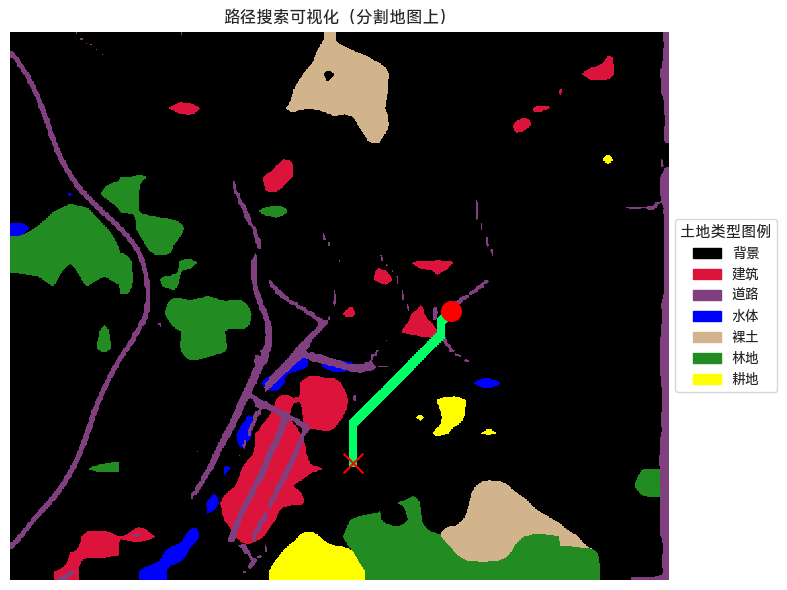

In [285]:
# === 绘制路径（绿色） ===
overlay = cost_map.copy()
overlay = np.stack([overlay] * 3, axis=-1)
overlay = np.log10(overlay) ** 0.5
overlay = overlay_mask_on_image(overlay, mask_val, id2color, alpha=1.0)
path_color = [0, 255, 100]  # RGB 绿色
thickness = 5  # 可调粗细

h, w = overlay.shape[:2]
for i, j in path:
    for di in range(-thickness, thickness + 1):
        for dj in range(-thickness, thickness + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < h and 0 <= nj < w:
                overlay[ni, nj] = path_color

plt.figure(figsize=(8, 6))
io.imshow(overlay)

# 起点圆圈（o）
plt.scatter(start_idx[1], start_idx[0], c="red", marker="o", s=200, label="Start")
# 终点叉号（x）
plt.scatter(end_idx[1], end_idx[0], c="red", marker="x", s=200, label="End")
plt.title("路径搜索可视化（分割地图上）")
plt.legend()
plt.axis("off")
plt.tight_layout()
# plt.show()
import matplotlib.patches as mpatches

# 构建图例句柄
legend_patches = []
for idx, row in df_label.iterrows():
    class_id = row["类别编号"]
    label_cn = row["类别名称（中文）"]
    color_rgb = id2color[class_id] / 255.0  # 归一化
    patch = mpatches.Patch(color=color_rgb, label=label_cn)
    legend_patches.append(patch)

plt.legend(
    handles=legend_patches,
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),  # 右边图外中间
    borderaxespad=0.0,
    title="土地类型图例",
    fontsize=10,
    title_fontsize=11,
    frameon=True
)


In [286]:
!jupyter nbconvert --to html road_plan3.ipynb
!jupyter nbconvert --to markdown road_plan3.ipynb

[NbConvertApp] Converting notebook road_plan3.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 2159586 bytes to road_plan3.html
[NbConvertApp] Converting notebook road_plan3.ipynb to markdown
[NbConvertApp] Support files will be in road_plan3_files\
[NbConvertApp] Writing 17387 bytes to road_plan3.md
